# RGI17 (Southern Andes)

F. Maussion & F. Roura Adserias

We were supposed to use the new Chile and argentina inventories. But because or problems in the Chile inventory and because of inconsistencies at the country border we can't do that. So we stick to RGI6 everywhere...

In [ ]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, open_zip_shapefile
import os

## Files and storage paths

In [ ]:
# Region of interest
reg = 17

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '17_rgi60_SouthernAndes.zip')

# Support data dir
support_dir = os.path.join(data_dir, 'l0_support_data')

### Load the input data

In [ ]:
# Read L2 files from GLIMS
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [ ]:
sdf, df_class = submission_summary(shp)
sdf

Notes based on manual observations:
- 510 to 516 are a few outlines in Patagonia
- 592 is RGI, looks spatially complete.
- 700 is the Argentina glacier inventory. 708 is an update of 75 of its outlines, for reasons quite unclear to me (the outlines are still in 700)
- 730 is the Chilan glacier inventory

both 700/708 and 720 have the same issues (rock glaciers) as for RGI16. Furthermore, the Argentina / Chile border makes both inventories pretty much useless as is.

In [ ]:
# # Write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_sel_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_sel_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_sel_inventories']))

## Outline selection 

In [ ]:
pata_icefield = shp.loc[shp.subm_id.isin([97, 98, 99, 100, 101])].copy()
rgi5 = shp.loc[shp.subm_id.isin([592])].copy()

In [ ]:
# Area around the icefield
box = open_zip_shapefile(support_dir + '/rgi17_exclude_592.zip')

In [ ]:
# Remove the icefield ids form rgi5
rp = rgi5.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = rgi5.index
difference = gpd.overlay(rp, box, how='difference')
rgi5 = rgi5.loc[difference['orig_index']].copy()

In [ ]:
# Size filter?
needs_size_filter(rgi5), needs_size_filter(pata_icefield)

In [ ]:
print(len(pata_icefield))
pata_icefield = size_filter(pata_icefield)
print(len(pata_icefield))

In [ ]:
rgi7 = pd.concat([rgi5, pata_icefield])
rgi7['is_rgi6'] = True

### Some sanity checks 

In [ ]:
sdf, df_class = submission_summary(rgi7)
df_class

In [ ]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area
        orphan_f = orphan_f.loc[orphan_f.subm_id.isin(rgi7.subm_id.unique()[check])]

In [ ]:
orphan_f['area'].sum() * 1e-6

### Plots 

In [ ]:
plot_map(rgi7, reg, aspect=0.8, loc='upper left')

In [ ]:
plot_map(rgi7, reg, aspect=0.8, loc='upper left', is_rgi6=True)

In [ ]:
plot_date_hist(rgi7, reg)

### Text for github

In [ ]:
fgh = sdf.T
fgh

In [ ]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

## Write out and tar 

In [ ]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

## Consistency check with RGI6 

In [ ]:
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [ ]:
len(rgi7), len(rgi6)

Test the areas:

In [ ]:
rgi6['area'] = rgi6.to_crs({'proj':'cea'}).area 

In [ ]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['area'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['area'].sum() - rgi7['area'].sum()) * 1e-6)

In [ ]:
# Remove the icefield ids form rgi5
rp = rgi6.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = rgi6.index

difference = gpd.overlay(rp, box, how='difference')
rgi6_nopata = rgi6.loc[difference['orig_index']].copy()
difference = gpd.overlay(rp, box, how='intersection')
rgi6_pata = rgi6.loc[difference['orig_index']].copy()
assert len(rgi6_nopata) + len(rgi6_pata) == len(rgi6)

In [ ]:
print(f'N1 = {len(pata_icefield)} , N2 = {len(rgi6_pata)}')
print('Area RGI7 pata (km2)', pata_icefield['area'].sum() * 1e-6)
print('Area RGI6 pata (km2)', rgi6_pata['area'].sum() * 1e-6)
print('diff', (rgi6_pata['area'].sum() - pata_icefield['area'].sum()) * 1e-6)

There are some small difference between RGI and what's in GLIMS. Let's just ignore them:

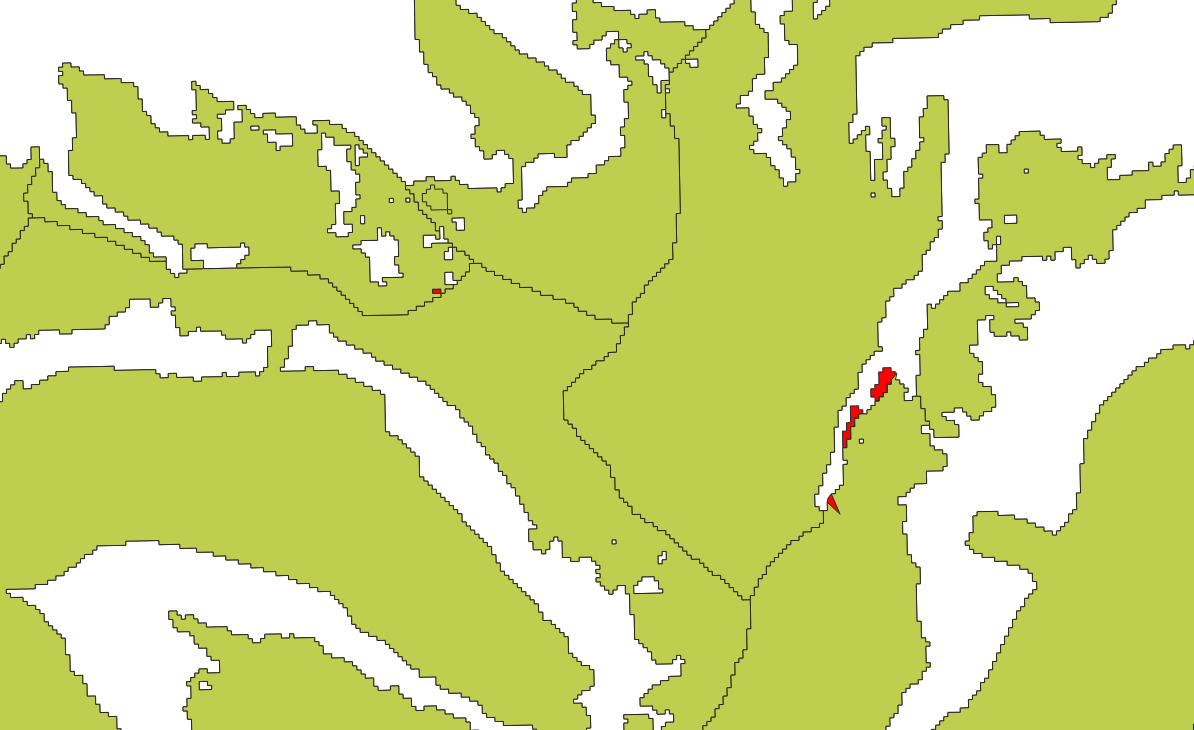